In [87]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from IPython.display import clear_output
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split

# Filtra todos os avisos do LightGBM
warnings.filterwarnings("ignore", category=UserWarning, message=".*lightgbm.*")

In [88]:
with open('database/df.pkl', 'rb') as f:
    df = pd.read_pickle(f)
    
df['date'] = pd.to_datetime(df['year_month'], format='%Y-%m')

#df.set_index('date', inplace=True)

# drop last row (2017-08) because it's incomplete // noise
df = df[df['date'] != '2017-08-01']

In [89]:
df_item = df[df['item_nbr'] == 870938]

In [90]:
def plot_forecast(train, test, forecast, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Original', color='blue')
    plt.plot(test.index, test['unit_sales'], label='Teste', color='orange')
    plt.plot(test.index, forecast, label='Previsão', color='red')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [91]:
ts = df_item[['year_month', 'unit_sales', 'onpromotion', 'oil_price']]
ts = ts.reset_index(drop=True)
ts['date'] = pd.to_datetime(ts['year_month'], format='%Y-%m')
ts = ts.set_index('date')
ts = ts.drop(columns=['year_month'])



train = ts.iloc[:-12]
test = ts.iloc[-12:]

/home/codespace/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


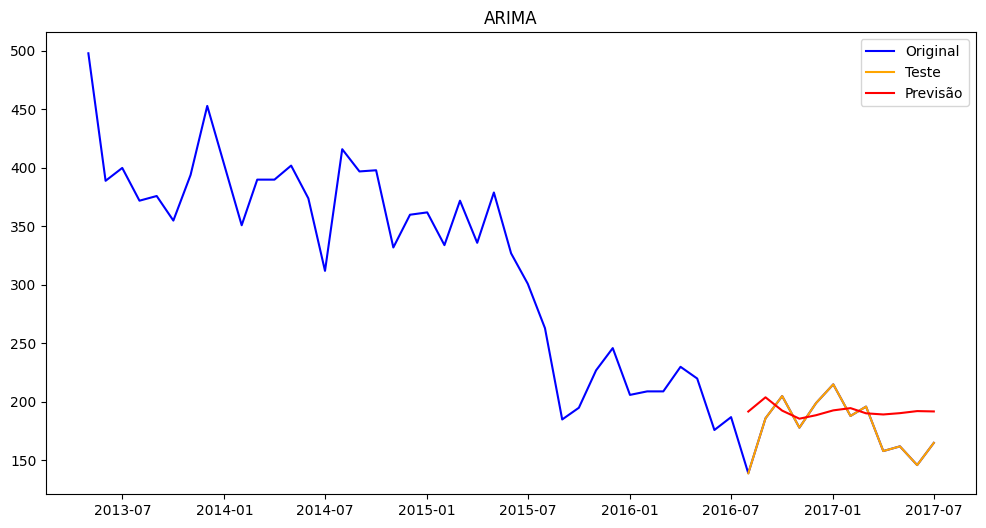

MSE: 719.6532335236528


In [103]:
# Ajustar o modelo ARIMA
model = ARIMA(train['unit_sales'], order=(5, 1, 0))  # (p, d, q) são os parâmetros do modelo ARIMA
model_fit = model.fit()
 
# Fazer previsões
forecast = model_fit.forecast(steps=12)

mse = mean_squared_error(test['unit_sales'], forecast)

plot_forecast(ts['unit_sales'], test, forecast, title="ARIMA")
print(f'MSE: {mse}')

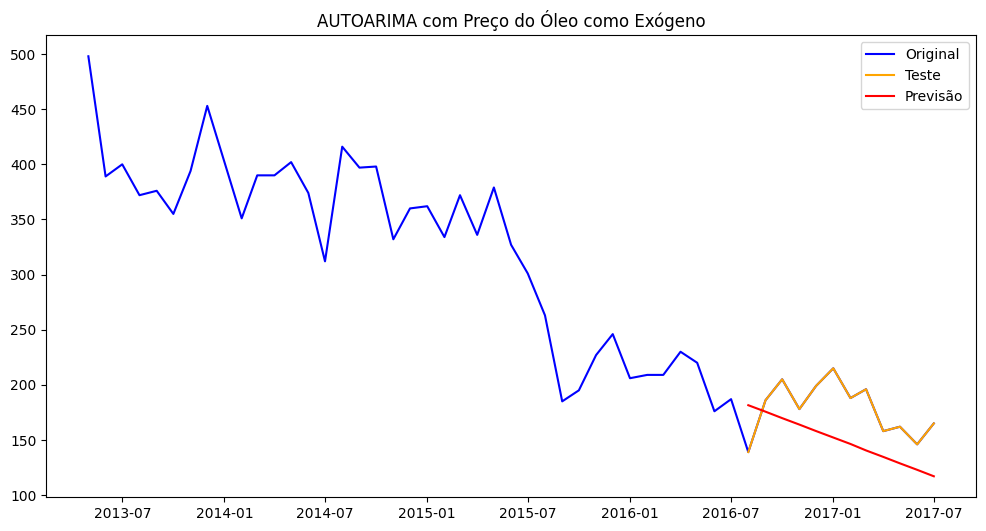

MSE: 1522.4280963756426


In [102]:
# using AUTOARIMA

# Correção na seleção de exógenos e na plotagem
model = auto_arima(train['unit_sales'], exogenous=train[['oil_price']], seasonal=True, m=12)
model.fit(train['unit_sales'], exogenous=train[['oil_price']])

# Ao prever, é necessário incluir os exógenos do conjunto de teste
forecast = model.predict(n_periods=len(test), exogenous=test[['oil_price']])

mse = mean_squared_error(test['unit_sales'], forecast)

plot_forecast(ts['unit_sales'], test, forecast, title="AUTOARIMA com Preço do Óleo como Exógeno")
print(f'MSE: {mse}')

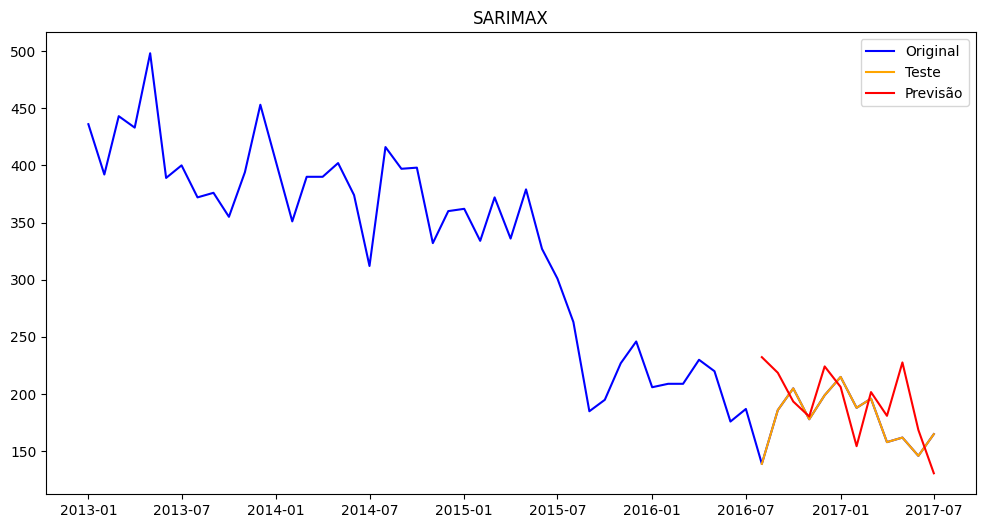

MSE: 1525.4084338506555


In [94]:
# using SARIMAX
model = SARIMAX(train['unit_sales'], exog=train[['oil_price']], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

forecast = model_fit.forecast(steps=12, exog=test[['oil_price']])
mse = mean_squared_error(test['unit_sales'], forecast)
clear_output()
plot_forecast(ts['unit_sales'], test, forecast, title="SARIMAX")
print(f'MSE: {mse}')